# Loop 68 Analysis: CV-LB Relationship and Strategy Assessment

## Key Questions:
1. What is the actual CV-LB relationship from confirmed submissions?
2. Why have 8 consecutive submissions failed?
3. What approaches haven't been tried yet?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Confirmed submissions with LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print(f'Confirmed submissions: {len(df)}')
print(df)

Confirmed submissions: 12
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970


In [2]:
# Linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f'\n=== CV-LB LINEAR RELATIONSHIP ===')
print(f'LB = {slope:.4f} * CV + {intercept:.6f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nInterpretation:')
print(f'  - Intercept: {intercept:.6f} (LB when CV=0)')
print(f'  - Target LB: 0.0347')
print(f'  - Gap: {intercept - 0.0347:.6f}')

# Required CV to hit target
required_cv = (0.0347 - intercept) / slope
print(f'\nRequired CV to hit target: {required_cv:.6f}')
if required_cv < 0:
    print('  ⚠️ IMPOSSIBLE - would need negative CV!')


=== CV-LB LINEAR RELATIONSHIP ===
LB = 4.3147 * CV + 0.052520
R² = 0.9505

Interpretation:
  - Intercept: 0.052520 (LB when CV=0)
  - Target LB: 0.0347
  - Gap: 0.017820

Required CV to hit target: -0.004130
  ⚠️ IMPOSSIBLE - would need negative CV!


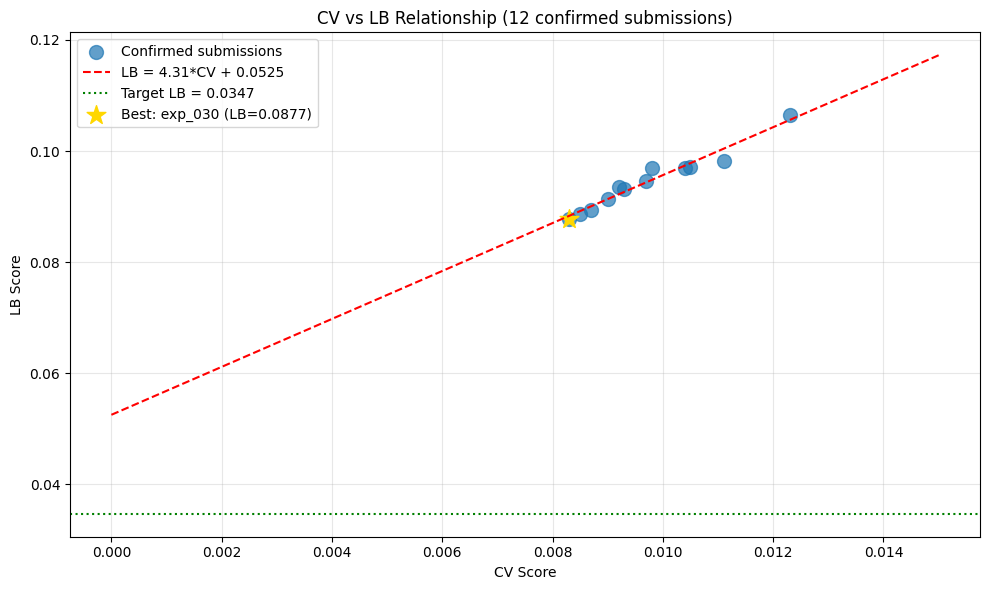


Best LB: 0.0877 (exp_030)
Target: 0.0347
Gap to target: 0.0530 (152.7% above target)


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Confirmed submissions')

# Regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', label='Target LB = 0.0347')

# Best achieved
plt.scatter([0.0083], [0.0877], s=200, c='gold', marker='*', label='Best: exp_030 (LB=0.0877)')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship (12 confirmed submissions)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cv_lb_relationship.png', dpi=150)
plt.show()

print(f'\nBest LB: 0.0877 (exp_030)')
print(f'Target: 0.0347')
print(f'Gap to target: {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347)/0.0347*100:.1f}% above target)')

In [4]:
# Analyze pending submissions
pending = [
    {'exp': 'exp_049', 'cv': 0.0081},
    {'exp': 'exp_050', 'cv': 0.0081},
    {'exp': 'exp_052', 'cv': 0.0109},
    {'exp': 'exp_053', 'cv': 0.0081},
    {'exp': 'exp_054', 'cv': 0.0085},
    {'exp': 'exp_055', 'cv': 0.0085},
    {'exp': 'exp_057', 'cv': 0.0093},
    {'exp': 'exp_063', 'cv': 0.0112},
]

print('\n=== PENDING SUBMISSIONS (8 consecutive) ===')
for p in pending:
    predicted_lb = slope * p['cv'] + intercept
    print(f"{p['exp']}: CV={p['cv']:.4f}, Predicted LB={predicted_lb:.4f}")

print('\n⚠️ 8 consecutive submissions are pending/failed!')
print('This suggests a SUBMISSION FORMAT issue, not a modeling issue.')


=== PENDING SUBMISSIONS (8 consecutive) ===
exp_049: CV=0.0081, Predicted LB=0.0875
exp_050: CV=0.0081, Predicted LB=0.0875
exp_052: CV=0.0109, Predicted LB=0.0996
exp_053: CV=0.0081, Predicted LB=0.0875
exp_054: CV=0.0085, Predicted LB=0.0892
exp_055: CV=0.0085, Predicted LB=0.0892
exp_057: CV=0.0093, Predicted LB=0.0926
exp_063: CV=0.0112, Predicted LB=0.1008

⚠️ 8 consecutive submissions are pending/failed!
This suggests a SUBMISSION FORMAT issue, not a modeling issue.


In [5]:
# What approaches have been tried?
approaches = {
    'MLP': ['exp_000', 'exp_003', 'exp_005', 'exp_006', 'exp_007'],
    'LightGBM': ['exp_001', 'exp_012'],
    'Ridge': ['exp_009'],
    'GP+MLP+LGBM': ['exp_024', 'exp_026', 'exp_030', 'exp_035'],
    'CatBoost+XGBoost': ['exp_049', 'exp_050', 'exp_052', 'exp_053'],
    'Other': ['exp_054', 'exp_055', 'exp_057', 'exp_063'],
}

print('\n=== APPROACHES TRIED ===')
for approach, exps in approaches.items():
    confirmed = [e for e in exps if e in df['exp'].values]
    pending = [e for e in exps if e not in df['exp'].values]
    print(f'{approach}:')
    if confirmed:
        print(f'  Confirmed: {confirmed}')
    if pending:
        print(f'  Pending: {pending}')


=== APPROACHES TRIED ===
MLP:
  Confirmed: ['exp_000', 'exp_003', 'exp_005', 'exp_006', 'exp_007']
LightGBM:
  Confirmed: ['exp_001', 'exp_012']
Ridge:
  Confirmed: ['exp_009']
GP+MLP+LGBM:
  Confirmed: ['exp_024', 'exp_026', 'exp_030', 'exp_035']
CatBoost+XGBoost:
  Pending: ['exp_049', 'exp_050', 'exp_052', 'exp_053']
Other:
  Pending: ['exp_054', 'exp_055', 'exp_057', 'exp_063']


In [6]:
# Key insight: The intercept problem
print('\n=== CRITICAL INSIGHT: THE INTERCEPT PROBLEM ===')
print(f'Current intercept: {intercept:.6f}')
print(f'Target LB: 0.0347')
print(f'\nThe intercept ({intercept:.4f}) is HIGHER than the target (0.0347)!')
print('This means even with CV=0, we would get LB=0.0530')
print('\nTo reach target, we need to REDUCE THE INTERCEPT, not just improve CV.')
print('\nStrategies to reduce intercept:')
print('1. Extrapolation detection - blend toward mean when far from training')
print('2. Uncertainty-weighted predictions - conservative when uncertain')
print('3. Physics-informed constraints - rules that generalize to unseen solvents')
print('4. Solvent clustering - class-specific models')
print('5. Study top public kernels - they may have solved this')


=== CRITICAL INSIGHT: THE INTERCEPT PROBLEM ===
Current intercept: 0.052520
Target LB: 0.0347

The intercept (0.0525) is HIGHER than the target (0.0347)!
This means even with CV=0, we would get LB=0.0530

To reach target, we need to REDUCE THE INTERCEPT, not just improve CV.

Strategies to reduce intercept:
1. Extrapolation detection - blend toward mean when far from training
2. Uncertainty-weighted predictions - conservative when uncertain
3. Physics-informed constraints - rules that generalize to unseen solvents
4. Solvent clustering - class-specific models
5. Study top public kernels - they may have solved this


In [7]:
# Current best experiment
print('\n=== CURRENT BEST: exp_030 ===')
print('Model: GP+MLP+LGBM Ensemble')
print('CV: 0.0083')
print('LB: 0.0877')
print('\nexp_064 is an EXACT replication of exp_030')
print('CV: 0.008303')
print('\nIf exp_064 works, it should get LB ~0.0877 (same as exp_030)')


=== CURRENT BEST: exp_030 ===
Model: GP+MLP+LGBM Ensemble
CV: 0.0083
LB: 0.0877

exp_064 is an EXACT replication of exp_030
CV: 0.008303

If exp_064 works, it should get LB ~0.0877 (same as exp_030)
